In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
from training import trainNet
from dataset import ImageDataset
from contrib import adf
import copy

# Fix seed for duplication
np.random.seed(123)
torch.manual_seed(123)

## Load data
Let's load the dataset

The label is :
7


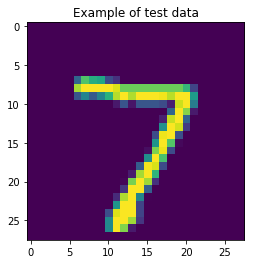

In [9]:
# Load input data and labels
data = torch.load("test.pt")
X = data[0]
Y = data[1]

# Visualize data
dataset = ImageDataset(X,Y) 
img = dataset[0][0]
label = dataset[0][1]
plt.imshow(img.numpy()[0])
plt.title("Example of test data")
print("The label is :")
print(label.numpy())

# Generate batches of test data(with imageDataset class above and torch.utils.data.DataLoader class)
testDataSet = ImageDataset(X,Y)
evalLoader = DataLoader(testDataSet,batch_size=64,shuffle=True)

# Set train to True if you need training and evaluation data loader
train = False
if train:
    # Split the dataset in train, val and test data (with sklearn.model_selection.train_test_split function)
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

    # Generate batches of train and val data (with imageDataset class above and torch.utils.data.DataLoader class)
    trainDataSet = ImageDataset(X_train,Y_train)
    testDataSet = ImageDataset(X_test,Y_test,train=False)
    trainLoader = DataLoader(trainDataSet,batch_size=128,shuffle=True)
    evalLoader = DataLoader(testDataSet,batch_size=128,shuffle=True)

## CNN model
This is a simple convolutionnal network with two convolutionnal layers and two dense layers.

Epoch: 1, Loss_train: 1.6552 (± 0.1666)
Epoch: 1, Loss_val: 1.5617 (± 0.0222)
Epoch: 2, Loss_train: 1.5472 (± 0.0226)
Epoch: 2, Loss_val: 1.5432 (± 0.0180)
Epoch: 3, Loss_train: 1.5304 (± 0.0185)
Epoch: 3, Loss_val: 1.5328 (± 0.0202)
Epoch: 4, Loss_train: 1.5194 (± 0.0176)
Epoch: 4, Loss_val: 1.5239 (± 0.0178)
Epoch: 5, Loss_train: 1.5117 (± 0.0165)
Epoch: 5, Loss_val: 1.5180 (± 0.0181)
Epoch: 6, Loss_train: 1.5064 (± 0.0159)
Epoch: 6, Loss_val: 1.5128 (± 0.0169)
Epoch: 7, Loss_train: 1.5014 (± 0.0152)
Epoch: 7, Loss_val: 1.5090 (± 0.0168)
Epoch: 8, Loss_train: 1.4973 (± 0.0146)
Epoch: 8, Loss_val: 1.5065 (± 0.0159)
Epoch: 9, Loss_train: 1.4935 (± 0.0140)
Epoch: 9, Loss_val: 1.5050 (± 0.0157)
Epoch: 10, Loss_train: 1.4906 (± 0.0140)
Epoch: 10, Loss_val: 1.5044 (± 0.0162)
Epoch: 11, Loss_train: 1.4880 (± 0.0124)
Epoch: 11, Loss_val: 1.5007 (± 0.0167)
Epoch: 12, Loss_train: 1.4861 (± 0.0122)
Epoch: 12, Loss_val: 1.4997 (± 0.0154)
Epoch: 13, Loss_train: 1.4846 (± 0.0121)
Epoch: 13, Loss_v

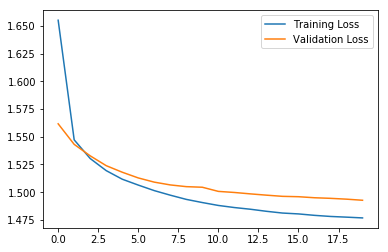

In [3]:

def keep_variance(x, min_variance):
    return x + min_variance

class MyADFNetwork(nn.Module):

    def __init__(self, noise_variance=1e-3, min_variance=1e-3):
        super(MyADFNetwork, self).__init__()
        # ADF parameters
        #self.keep_variance_fn = lambda x: keep_variance(x, min_variance=min_variance)
        self.keep_variance_fn = None
        self._noise_variance = noise_variance
        # an affine operation: y = Wx + b
        self.fc1 = adf.Linear(784, 128, keep_variance_fn=self.keep_variance_fn) 
        self.fc2 = adf.Linear(128, 10, keep_variance_fn=self.keep_variance_fn)
        self.relu = adf.ReLU(keep_variance_fn=self.keep_variance_fn)
        self.softmax = adf.Softmax(keep_variance_fn=self.keep_variance_fn,dim=1)

    # Forward function of the classification model
    def forward(self, input):
        inputs_mean = torch.reshape(input,(input.shape[0],-1))
        inputs_variance = torch.zeros_like(inputs_mean) + self._noise_variance
        x = inputs_mean, inputs_variance
        
        x = self.relu(*self.fc1(*x))
        x = self.softmax(*self.fc2(*x))
        return x

# Test
net = MyADFNetwork()
y, z = net(torch.ones(1,1,28,28))

# Train
if train:
    trainNet(net, trainLoader, evalLoader, ADF=True)

## Evaluate the model
The model has allready been trained and is stored on netMNIST.pt. Let's check if it works

In [10]:
# Load classification model with its weights
model = MyADFNetwork()
model.load_state_dict(torch.load('netMNISTADF.pt'))
model.eval()

# Generate batches of test data 
loader_test = evalLoader

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# Testing
with torch.no_grad(): # no gradient
    for i, data in enumerate(loader_test):

        # Load image and class inside a batch 
        imgs = data[0]
        labels = data[1]

        # Apply the model
        preds,_ = model(imgs)
        v, i = torch.max(preds,1)

        # Append batch prediction results
        predlist=torch.cat([predlist,i.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Display results
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

# accuracy
print(np.mean(class_accuracy))
    

[[ 969    0    1    2    1    3    1    1    2    0]
 [   0 1123    4    2    0    1    1    1    3    0]
 [   8    2  993    7    3    0    3   10    6    0]
 [   0    0    4  988    1    2    1    7    7    0]
 [   2    1    2    0  962    0    5    2    0    8]
 [   3    0    0    9    1  871    4    0    2    2]
 [   9    2    1    0    3   13  923    1    6    0]
 [   0    7    9    4    1    1    0  999    3    4]
 [   6    2    3   13    6    8    4    7  918    7]
 [   4    4    1    8   10    4    1    7    3  967]]
[98.87755102 98.94273128 96.22093023 97.82178218 97.96334012 97.64573991
 96.34655532 97.17898833 94.25051335 95.83746283]
97.1085594573182


# ADF uncertainties estimation
Let's see if the network has an idea about adversarial inputs

Mean estimation : 1
With an uncertainty of: 0.055227067321538925


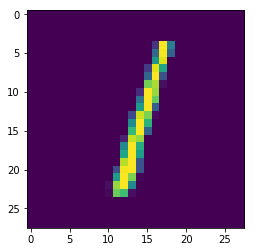

In [29]:
# select an image in the evaluation se
i = 2
img = torch.unsqueeze(testDataSet[i][0],0)

avg0, cov0 = model(img)
numpyImage = img.numpy()        
plt.imshow(numpyImage[0][0])
class0 =  np.argmax(avg0.detach().numpy())
cov0 = cov0.detach().numpy()[0][class0]
print("Mean estimation : {}".format(class0))
print("With an uncertainty of: {}".format(cov0))


Now let's compute the matrix for a noisy image

Mean estimation : 8
With an uncertainty of: 0.037619028240442276


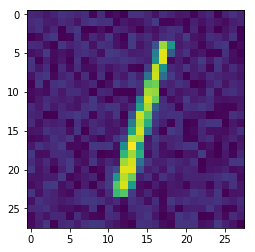

In [31]:
# We generate an unknown image
sigma = 0.2
noise = sigma*np.random.rand(28,28)
# randIm = img[0][0].numpy()[::-1,::-1]
im = img[0][0].numpy() + noise
noisyTensor = torch.unsqueeze(torch.FloatTensor(im),0)
noisyTensor = torch.unsqueeze(noisyTensor,0)

# Let's compute the covariance matrix
plt.imshow(noisyTensor.numpy()[0][0])
avg1, cov1 = model(noisyTensor)
class1 =  np.argmax(avg1.detach().numpy())
cov1 = cov1.detach().numpy()[0][class1]
print("Mean estimation : {}".format(class1))
print("With an uncertainty of: {}".format(cov1))

Let's try it for a rotated image

Mean estimation : 1
With an uncertainty of: 0.09362847357988358


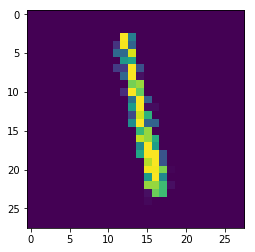

In [32]:
# let's rotate the image
angle = 30
rotatedTensor = TF.rotate(img, angle)


# Let's compute the covariance matrix
plt.imshow(rotatedTensor.numpy()[0][0])
avg2, cov2 = model(rotatedTensor)
class2 =  np.argmax(avg2.detach().numpy())
cov2 = cov2.detach().numpy()[0][class2]
print("Mean estimation : {}".format(class2))
print("With an uncertainty of: {}".format(cov2))